Project root added to sys.path: d:\Handwritten Digit Recognition
Epoch 1/5


d:\Handwritten Digit Recognition\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


391/391 - 5s - 12ms/step - accuracy: 0.8633 - loss: 1.1204
Epoch 2/5
391/391 - 4s - 11ms/step - accuracy: 0.9596 - loss: 0.1399
Epoch 3/5
391/391 - 4s - 11ms/step - accuracy: 0.9755 - loss: 0.0811
Epoch 4/5
391/391 - 4s - 10ms/step - accuracy: 0.9826 - loss: 0.0573
Epoch 5/5
391/391 - 5s - 13ms/step - accuracy: 0.9866 - loss: 0.0427
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

 Test Accuracy: 0.9807
⏱ Training time: 22.26 sec
⏱ Prediction time: 0.96 sec

 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.97      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97

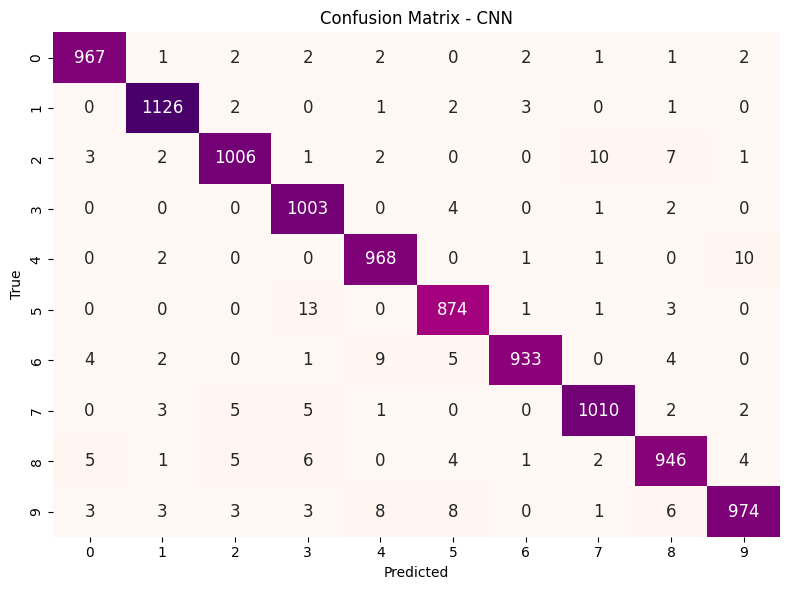

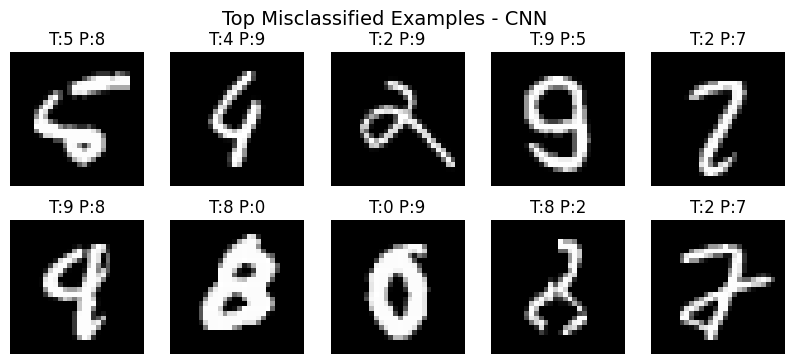

In [1]:
%run ../utils/init_notebook.py

from utils.data_loader import load_mnist
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Load data (raw pixels)
X_train, y_train, X_test, y_test = load_mnist(normalise=False)

# Take a subset
subset_size = 50000
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

# Reshape for CNN input
X_train_cnn = X_train_sub.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train_cat = to_categorical(y_train_sub, 10)
y_test_cat = to_categorical(y_test, 10)

# Simple CNN model
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_train = time.time()
model.fit(X_train_cnn, y_train_cat, epochs=5, batch_size=128, verbose=2)
end_train = time.time()

start_pred = time.time()
y_pred_prob = model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_prob, axis=1)
end_pred = time.time()

acc_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"\n Test Accuracy: {acc_cnn:.4f}")
print(f"⏱ Training time: {end_train - start_train:.2f} sec")
print(f"⏱ Prediction time: {end_pred - start_pred:.2f} sec")

print("\n Classification Report:")
print(classification_report(y_test, y_pred_cnn))

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="RdPu", cbar=False, annot_kws={"size": 12})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN")
plt.tight_layout()
plt.show()

misclassified_idx_cnn = np.where(y_pred_cnn != y_test)[0]
plt.figure(figsize=(10, 4))
for i, idx in enumerate(misclassified_idx_cnn[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"T:{y_test[idx]} P:{y_pred_cnn[idx]}")
    plt.axis('off')
plt.suptitle("Top Misclassified Examples - CNN", fontsize=14)
plt.show()

In [2]:
import os
import pandas as pd
import joblib

# Path for accuracy log file
ACC_LOG = "results/model_accuracies.csv"

# Append model name + accuracy
model_name = "Simple CNN"  

results_dir = os.path.join("..", "results")
os.makedirs(results_dir, exist_ok=True)
results_file = os.path.join(results_dir, "accuracies.csv")

# Append or Create CSV
if os.path.exists(results_file):
    df = pd.read_csv(results_file)
    df = df[["model_name", "accuracy_value"]] if "accuracy_value" in df.columns else pd.DataFrame(columns=["model_name", "accuracy_value"])
else:
    df = pd.DataFrame(columns=["model_name", "accuracy_value"])

# Remove old entry if model already logged (to avoid duplicates)
df = df[df["model_name"] != model_name]

# Add new row
df = pd.concat([df, pd.DataFrame([{
    "model_name": model_name,
    "accuracy_value": acc_cnn
}])], ignore_index=True)

# Save
df.to_csv(results_file, index=False)

# Save model
joblib.dump(model, f"../results/{model_name}.pkl")

print(f"Accuracy logged for model '{model_name}' in {results_file}")
print(f"Model saved as ../results/{model_name}.pkl")

Accuracy logged for model 'Simple CNN' in ..\results\accuracies.csv
Model saved as ../results/Simple CNN.pkl
